In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from matplotlib import pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers, callbacks
from keras.layers import Dense, Dropout, BatchNormalization

# Load Data 

In [2]:
df = pd.read_csv('Preprocessed Data 3 Mar 2021.csv', index_col = 0)
df.head(5)

,Speed (km/h),Latitude coordinate (degrees),Longitude coordinate (degrees),Altitude (meters),Vertical accuracy (degrees),Horizontal accuracy (degrees),Course (degrees),Difcourse: course variation (degrees),Acceleration in X filtered by KF (Gs),Acceleration in Y filtered by KF (Gs),...,no speed limit,no lanes number,Type of road_motorway,Type of road_motorway_link,Type of road_primary,Type of road_primary_link,Type of road_tertiary_link,AGGRESSIVE,DROWSY,NORMAL
0,64.5,40.512924,-3.404577,612.5,4,5,331.9,0.000,-0.030,-0.015,...,0,0,0,0,0,0,0,0,0,1
1,63.6,40.513065,-3.404680,612.9,4,5,330.8,1.055,0.026,-0.012,...,0,0,0,0,0,0,0,0,0,1
2,62.2,40.513210,-3.404772,613.3,4,5,330.8,1.055,-0.021,-0.018,...,0,0,0,0,0,0,0,0,0,1
3,60.9,40.513348,-3.404868,613.5,3,5,330.1,0.703,0.025,0.006,...,0,0,0,0,0,0,0,0,0,1
4,61.2,40.513477,-3.404971,613.8,3,5,329.4,1.406,0.014,-0.031,...,0,0,0,0,0,0,0,0,0,1


# K-Fold Cross Validation

In [3]:
from sklearn.model_selection import KFold
X = df.iloc[:,:-3]
Y = df.iloc[:,-3:]
kf = KFold(n_splits=5, random_state=4, shuffle=True)

# Training

In [4]:
count = 0

for train_index, test_index in kf.split(X):
    print('Fold: ' + str(count))

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    X_train = X_train.reshape(X_train.shape[0],1,X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0],1,X_test.shape[1])
    
    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=40)

    model = keras.Sequential()
    
    model.add(layers.SimpleRNN(units=100, input_shape=(1,X_train.shape[2]), return_sequences=True, activation="tanh"))
    model.add(Dropout(0.0005))
    model.add(BatchNormalization())
    
    model.add(layers.SimpleRNN(units=100, return_sequences=True, activation="tanh"))
    model.add(Dropout(0.0005))
    model.add(BatchNormalization())
    
    model.add(layers.SimpleRNN(units=100, return_sequences=True, activation="tanh"))
    model.add(Dropout(0.0005))
    model.add(BatchNormalization())
    
    model.add(layers.SimpleRNN(units=100, activation="tanh"))
    model.add(Dropout(0.0005))
    model.add(BatchNormalization())
    
    model.add(Dense(3, 'softmax'))

    optimizer = keras.optimizers.Adam()

    model.compile(optimizer=optimizer,
                 loss='categorical_crossentropy',
                 metrics = 'accuracy')

    model.summary()
    
    history = model.fit(X_train, Y_train, 
                    validation_data=(X_test, Y_test), 
                    #batch_size = 22,
                    callbacks=[early_stopping],
                    epochs=600)
    
    if count == 0:
        history_fold_0 = pd.DataFrame(history.history)
    elif count == 1:
        history_fold_1 = pd.DataFrame(history.history)
    elif count == 2:
        history_fold_2 = pd.DataFrame(history.history)
    elif count == 3:
        history_fold_3 = pd.DataFrame(history.history)
    elif count == 4:
        history_fold_4 = pd.DataFrame(history.history)
    
    count += 1

Fold: 0
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 1, 100)            14100     
_________________________________________________________________
dropout (Dropout)            (None, 1, 100)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 100)            400       
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 1, 100)            20100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 100)            0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 100)            400       
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 1, 100)     

769/769 [==============================] - 4s 5ms/step - loss: 0.1292 - accuracy: 0.9527 - val_loss: 0.1275 - val_accuracy: 0.9580
Epoch 44/600
769/769 [==============================] - 4s 5ms/step - loss: 0.1262 - accuracy: 0.9532 - val_loss: 0.1310 - val_accuracy: 0.9546
Epoch 45/600
769/769 [==============================] - 4s 5ms/step - loss: 0.1273 - accuracy: 0.9529 - val_loss: 0.1314 - val_accuracy: 0.9548
Epoch 46/600
769/769 [==============================] - 4s 5ms/step - loss: 0.1216 - accuracy: 0.9547 - val_loss: 0.1075 - val_accuracy: 0.9637
Epoch 47/600
769/769 [==============================] - 4s 5ms/step - loss: 0.1148 - accuracy: 0.9581 - val_loss: 0.1186 - val_accuracy: 0.9616
Epoch 48/600
769/769 [==============================] - 4s 5ms/step - loss: 0.1237 - accuracy: 0.9549 - val_loss: 0.1257 - val_accuracy: 0.9553
Epoch 49/600
769/769 [==============================] - 4s 5ms/step - loss: 0.1169 - accuracy: 0.9575 - val_loss: 0.1271 - val_accuracy: 0.9575
Epoch

Epoch 100/600
769/769 [==============================] - 4s 5ms/step - loss: 0.0875 - accuracy: 0.9684 - val_loss: 0.0995 - val_accuracy: 0.9702
Epoch 101/600
769/769 [==============================] - 4s 5ms/step - loss: 0.0868 - accuracy: 0.9685 - val_loss: 0.1047 - val_accuracy: 0.9660
Epoch 102/600
769/769 [==============================] - 4s 5ms/step - loss: 0.0800 - accuracy: 0.9703 - val_loss: 0.1102 - val_accuracy: 0.9649
Epoch 103/600
769/769 [==============================] - 4s 5ms/step - loss: 0.0892 - accuracy: 0.9687 - val_loss: 0.0882 - val_accuracy: 0.9719
Epoch 104/600
769/769 [==============================] - 4s 5ms/step - loss: 0.0801 - accuracy: 0.9715 - val_loss: 0.1075 - val_accuracy: 0.9657
Epoch 105/600
769/769 [==============================] - 4s 5ms/step - loss: 0.0814 - accuracy: 0.9705 - val_loss: 0.1101 - val_accuracy: 0.9616
Epoch 106/600
769/769 [==============================] - 4s 5ms/step - loss: 0.0868 - accuracy: 0.9687 - val_loss: 0.0917 - val_ac

769/769 [==============================] - 4s 6ms/step - loss: 0.6944 - accuracy: 0.6837 - val_loss: 0.6428 - val_accuracy: 0.7106
Epoch 2/600
769/769 [==============================] - 3s 4ms/step - loss: 0.5011 - accuracy: 0.7839 - val_loss: 0.3849 - val_accuracy: 0.8326
Epoch 3/600
769/769 [==============================] - 3s 4ms/step - loss: 0.4051 - accuracy: 0.8314 - val_loss: 0.3460 - val_accuracy: 0.8598
Epoch 4/600
769/769 [==============================] - 3s 4ms/step - loss: 0.3539 - accuracy: 0.8560 - val_loss: 0.3085 - val_accuracy: 0.8717
Epoch 5/600
769/769 [==============================] - 3s 4ms/step - loss: 0.3171 - accuracy: 0.8733 - val_loss: 0.2428 - val_accuracy: 0.9044
Epoch 6/600
769/769 [==============================] - 3s 4ms/step - loss: 0.2908 - accuracy: 0.8841 - val_loss: 0.2305 - val_accuracy: 0.9117
Epoch 7/600
769/769 [==============================] - 3s 4ms/step - loss: 0.2735 - accuracy: 0.8946 - val_loss: 0.2213 - val_accuracy: 0.9131
Epoch 8/600

769/769 [==============================] - 3s 4ms/step - loss: 0.1145 - accuracy: 0.9589 - val_loss: 0.1072 - val_accuracy: 0.9631
Epoch 59/600
769/769 [==============================] - 3s 4ms/step - loss: 0.1105 - accuracy: 0.9591 - val_loss: 0.1068 - val_accuracy: 0.9621
Epoch 60/600
769/769 [==============================] - 3s 4ms/step - loss: 0.1081 - accuracy: 0.9610 - val_loss: 0.1075 - val_accuracy: 0.9615
Epoch 61/600
769/769 [==============================] - 3s 4ms/step - loss: 0.1110 - accuracy: 0.9586 - val_loss: 0.1022 - val_accuracy: 0.9652
Epoch 62/600
769/769 [==============================] - 3s 4ms/step - loss: 0.1082 - accuracy: 0.9594 - val_loss: 0.1113 - val_accuracy: 0.9588
Epoch 63/600
769/769 [==============================] - 3s 4ms/step - loss: 0.1140 - accuracy: 0.9581 - val_loss: 0.1099 - val_accuracy: 0.9644
Epoch 64/600
769/769 [==============================] - 3s 4ms/step - loss: 0.1086 - accuracy: 0.9613 - val_loss: 0.0996 - val_accuracy: 0.9628
Epoch

Epoch 115/600
769/769 [==============================] - 3s 4ms/step - loss: 0.0872 - accuracy: 0.9689 - val_loss: 0.0985 - val_accuracy: 0.9675
Epoch 116/600
769/769 [==============================] - 3s 4ms/step - loss: 0.0826 - accuracy: 0.9705 - val_loss: 0.1086 - val_accuracy: 0.9619
Epoch 117/600
769/769 [==============================] - 3s 4ms/step - loss: 0.0819 - accuracy: 0.9704 - val_loss: 0.1131 - val_accuracy: 0.9652
Epoch 118/600
769/769 [==============================] - 3s 4ms/step - loss: 0.0823 - accuracy: 0.9704 - val_loss: 0.0817 - val_accuracy: 0.9743
Epoch 119/600
769/769 [==============================] - 3s 4ms/step - loss: 0.0846 - accuracy: 0.9688 - val_loss: 0.0793 - val_accuracy: 0.9736
Epoch 120/600
769/769 [==============================] - 3s 4ms/step - loss: 0.0792 - accuracy: 0.9721 - val_loss: 0.0937 - val_accuracy: 0.9697
Epoch 121/600
769/769 [==============================] - 3s 4ms/step - loss: 0.0806 - accuracy: 0.9709 - val_loss: 0.0935 - val_ac

769/769 [==============================] - 4s 5ms/step - loss: 0.0739 - accuracy: 0.9734 - val_loss: 0.0811 - val_accuracy: 0.9761
Epoch 172/600
769/769 [==============================] - 4s 5ms/step - loss: 0.0646 - accuracy: 0.9774 - val_loss: 0.0753 - val_accuracy: 0.9777
Epoch 173/600
769/769 [==============================] - 4s 5ms/step - loss: 0.0652 - accuracy: 0.9770 - val_loss: 0.0868 - val_accuracy: 0.9735
Epoch 174/600
769/769 [==============================] - 4s 5ms/step - loss: 0.0646 - accuracy: 0.9778 - val_loss: 0.0708 - val_accuracy: 0.9774
Epoch 175/600
769/769 [==============================] - 4s 5ms/step - loss: 0.0673 - accuracy: 0.9758 - val_loss: 0.0759 - val_accuracy: 0.9772
Epoch 176/600
769/769 [==============================] - 4s 5ms/step - loss: 0.0651 - accuracy: 0.9765 - val_loss: 0.0763 - val_accuracy: 0.9754
Epoch 177/600
769/769 [==============================] - 3s 4ms/step - loss: 0.0608 - accuracy: 0.9781 - val_loss: 0.0742 - val_accuracy: 0.9761

769/769 [==============================] - 4s 5ms/step - loss: 0.0564 - accuracy: 0.9796 - val_loss: 0.1032 - val_accuracy: 0.9688
Epoch 228/600
769/769 [==============================] - 4s 5ms/step - loss: 0.0584 - accuracy: 0.9797 - val_loss: 0.0764 - val_accuracy: 0.9748
Epoch 229/600
769/769 [==============================] - 4s 5ms/step - loss: 0.0494 - accuracy: 0.9823 - val_loss: 0.0765 - val_accuracy: 0.9774
Epoch 230/600
769/769 [==============================] - 4s 5ms/step - loss: 0.0544 - accuracy: 0.9806 - val_loss: 0.0739 - val_accuracy: 0.9761
Epoch 231/600
769/769 [==============================] - 4s 5ms/step - loss: 0.0536 - accuracy: 0.9806 - val_loss: 0.0727 - val_accuracy: 0.9774
Epoch 232/600
769/769 [==============================] - 4s 5ms/step - loss: 0.0573 - accuracy: 0.9799 - val_loss: 0.0792 - val_accuracy: 0.9741
Epoch 233/600
769/769 [==============================] - 4s 5ms/step - loss: 0.0570 - accuracy: 0.9802 - val_loss: 0.0807 - val_accuracy: 0.9756

769/769 [==============================] - 4s 5ms/step - loss: 0.0497 - accuracy: 0.9824 - val_loss: 0.0676 - val_accuracy: 0.9800
Epoch 284/600
769/769 [==============================] - 4s 5ms/step - loss: 0.0444 - accuracy: 0.9848 - val_loss: 0.0753 - val_accuracy: 0.9782
Epoch 285/600
769/769 [==============================] - 4s 5ms/step - loss: 0.0483 - accuracy: 0.9835 - val_loss: 0.0695 - val_accuracy: 0.9779
Epoch 286/600
769/769 [==============================] - 4s 5ms/step - loss: 0.0484 - accuracy: 0.9838 - val_loss: 0.0739 - val_accuracy: 0.9766
Epoch 287/600
769/769 [==============================] - 4s 5ms/step - loss: 0.0490 - accuracy: 0.9824 - val_loss: 0.0749 - val_accuracy: 0.9771
Epoch 288/600
769/769 [==============================] - 4s 5ms/step - loss: 0.0450 - accuracy: 0.9842 - val_loss: 0.0766 - val_accuracy: 0.9774
Epoch 289/600
769/769 [==============================] - 4s 5ms/step - loss: 0.0467 - accuracy: 0.9847 - val_loss: 0.0690 - val_accuracy: 0.9780

Epoch 1/600
769/769 [==============================] - 8s 10ms/step - loss: 0.6955 - accuracy: 0.6837 - val_loss: 0.5775 - val_accuracy: 0.7428
Epoch 2/600
769/769 [==============================] - 5s 7ms/step - loss: 0.5023 - accuracy: 0.7857 - val_loss: 0.4679 - val_accuracy: 0.8007
Epoch 3/600
769/769 [==============================] - 5s 7ms/step - loss: 0.4075 - accuracy: 0.8317 - val_loss: 0.3296 - val_accuracy: 0.8678
Epoch 4/600
769/769 [==============================] - 5s 7ms/step - loss: 0.3434 - accuracy: 0.8618 - val_loss: 0.3120 - val_accuracy: 0.8751
Epoch 5/600
769/769 [==============================] - 5s 7ms/step - loss: 0.3120 - accuracy: 0.8755 - val_loss: 0.2765 - val_accuracy: 0.8884
Epoch 6/600
769/769 [==============================] - 5s 7ms/step - loss: 0.2852 - accuracy: 0.8859 - val_loss: 0.2297 - val_accuracy: 0.9151
Epoch 7/600
769/769 [==============================] - 4s 6ms/step - loss: 0.2633 - accuracy: 0.8975 - val_loss: 0.2331 - val_accuracy: 0.906

769/769 [==============================] - 5s 7ms/step - loss: 0.1147 - accuracy: 0.9585 - val_loss: 0.1227 - val_accuracy: 0.9611
Epoch 58/600
769/769 [==============================] - 4s 5ms/step - loss: 0.1109 - accuracy: 0.9589 - val_loss: 0.1096 - val_accuracy: 0.9624
Epoch 59/600
769/769 [==============================] - 5s 7ms/step - loss: 0.1130 - accuracy: 0.9580 - val_loss: 0.0933 - val_accuracy: 0.9683
Epoch 60/600
769/769 [==============================] - 5s 7ms/step - loss: 0.1080 - accuracy: 0.9614 - val_loss: 0.1037 - val_accuracy: 0.9634
Epoch 61/600
769/769 [==============================] - 5s 6ms/step - loss: 0.1120 - accuracy: 0.9587 - val_loss: 0.0923 - val_accuracy: 0.9699
Epoch 62/600
769/769 [==============================] - 5s 6ms/step - loss: 0.1145 - accuracy: 0.9586 - val_loss: 0.0961 - val_accuracy: 0.9667
Epoch 63/600
769/769 [==============================] - 5s 6ms/step - loss: 0.1119 - accuracy: 0.9589 - val_loss: 0.0993 - val_accuracy: 0.9645
Epoch

Epoch 114/600
769/769 [==============================] - 6s 7ms/step - loss: 0.0835 - accuracy: 0.9694 - val_loss: 0.0751 - val_accuracy: 0.9754
Epoch 115/600
769/769 [==============================] - 5s 7ms/step - loss: 0.0812 - accuracy: 0.9708 - val_loss: 0.0875 - val_accuracy: 0.9710
Epoch 116/600
769/769 [==============================] - 6s 7ms/step - loss: 0.0800 - accuracy: 0.9713 - val_loss: 0.0854 - val_accuracy: 0.9699
Epoch 117/600
769/769 [==============================] - 5s 7ms/step - loss: 0.0810 - accuracy: 0.9714 - val_loss: 0.1044 - val_accuracy: 0.9667
Epoch 118/600
769/769 [==============================] - 5s 6ms/step - loss: 0.0840 - accuracy: 0.9695 - val_loss: 0.0765 - val_accuracy: 0.9738
Epoch 119/600
769/769 [==============================] - 5s 7ms/step - loss: 0.0813 - accuracy: 0.9707 - val_loss: 0.0707 - val_accuracy: 0.9779
Epoch 120/600
769/769 [==============================] - 5s 7ms/step - loss: 0.0827 - accuracy: 0.9700 - val_loss: 0.0759 - val_ac

769/769 [==============================] - 5s 7ms/step - loss: 0.0647 - accuracy: 0.9767 - val_loss: 0.0687 - val_accuracy: 0.9797
Epoch 171/600
769/769 [==============================] - 5s 7ms/step - loss: 0.0655 - accuracy: 0.9767 - val_loss: 0.0738 - val_accuracy: 0.9793
Epoch 172/600
769/769 [==============================] - 5s 7ms/step - loss: 0.0686 - accuracy: 0.9760 - val_loss: 0.0747 - val_accuracy: 0.9758
Epoch 173/600
769/769 [==============================] - 5s 7ms/step - loss: 0.0616 - accuracy: 0.9774 - val_loss: 0.0807 - val_accuracy: 0.9754
Epoch 174/600
769/769 [==============================] - 5s 6ms/step - loss: 0.0615 - accuracy: 0.9782 - val_loss: 0.0744 - val_accuracy: 0.9780
Epoch 175/600
769/769 [==============================] - 5s 6ms/step - loss: 0.0646 - accuracy: 0.9775 - val_loss: 0.0800 - val_accuracy: 0.9756
Epoch 176/600
769/769 [==============================] - 5s 6ms/step - loss: 0.0643 - accuracy: 0.9776 - val_loss: 0.0773 - val_accuracy: 0.9776

769/769 [==============================] - 5s 6ms/step - loss: 0.0551 - accuracy: 0.9810 - val_loss: 0.0730 - val_accuracy: 0.9780
Epoch 227/600
769/769 [==============================] - 5s 6ms/step - loss: 0.0612 - accuracy: 0.9789 - val_loss: 0.0712 - val_accuracy: 0.9784
Epoch 228/600
769/769 [==============================] - 5s 6ms/step - loss: 0.0562 - accuracy: 0.9795 - val_loss: 0.0796 - val_accuracy: 0.9756
Epoch 229/600
769/769 [==============================] - 5s 6ms/step - loss: 0.0522 - accuracy: 0.9824 - val_loss: 0.0657 - val_accuracy: 0.9797
Epoch 230/600
769/769 [==============================] - 5s 6ms/step - loss: 0.0614 - accuracy: 0.9785 - val_loss: 0.0708 - val_accuracy: 0.9785
Epoch 231/600
769/769 [==============================] - 5s 6ms/step - loss: 0.0530 - accuracy: 0.9821 - val_loss: 0.0602 - val_accuracy: 0.9824
Epoch 232/600
769/769 [==============================] - 5s 6ms/step - loss: 0.0502 - accuracy: 0.9829 - val_loss: 0.0722 - val_accuracy: 0.9780

769/769 [==============================] - 6s 8ms/step - loss: 0.1958 - accuracy: 0.9253 - val_loss: 0.1453 - val_accuracy: 0.9453
Epoch 15/600
769/769 [==============================] - 6s 7ms/step - loss: 0.1857 - accuracy: 0.9299 - val_loss: 0.1720 - val_accuracy: 0.9374
Epoch 16/600
769/769 [==============================] - 7s 9ms/step - loss: 0.1902 - accuracy: 0.9281 - val_loss: 0.1506 - val_accuracy: 0.9434
Epoch 17/600
769/769 [==============================] - 6s 8ms/step - loss: 0.1834 - accuracy: 0.9313 - val_loss: 0.1590 - val_accuracy: 0.9377
Epoch 18/600
769/769 [==============================] - 6s 7ms/step - loss: 0.1740 - accuracy: 0.9334 - val_loss: 0.1632 - val_accuracy: 0.9431
Epoch 19/600
769/769 [==============================] - 7s 8ms/step - loss: 0.1769 - accuracy: 0.9330 - val_loss: 0.1517 - val_accuracy: 0.9463
Epoch 20/600
769/769 [==============================] - 7s 9ms/step - loss: 0.1804 - accuracy: 0.9310 - val_loss: 0.1377 - val_accuracy: 0.9519
Epoch

Epoch 71/600
769/769 [==============================] - 6s 8ms/step - loss: 0.1020 - accuracy: 0.9626 - val_loss: 0.0900 - val_accuracy: 0.9694
Epoch 72/600
769/769 [==============================] - 6s 7ms/step - loss: 0.1053 - accuracy: 0.9612 - val_loss: 0.0800 - val_accuracy: 0.9722
Epoch 73/600
769/769 [==============================] - 5s 7ms/step - loss: 0.1050 - accuracy: 0.9608 - val_loss: 0.0911 - val_accuracy: 0.9720
Epoch 74/600
769/769 [==============================] - 6s 8ms/step - loss: 0.1019 - accuracy: 0.9634 - val_loss: 0.0952 - val_accuracy: 0.9694
Epoch 75/600
769/769 [==============================] - 6s 7ms/step - loss: 0.1033 - accuracy: 0.9615 - val_loss: 0.0969 - val_accuracy: 0.9683
Epoch 76/600
769/769 [==============================] - 6s 7ms/step - loss: 0.0982 - accuracy: 0.9631 - val_loss: 0.0925 - val_accuracy: 0.9702
Epoch 77/600
769/769 [==============================] - 6s 7ms/step - loss: 0.0933 - accuracy: 0.9670 - val_loss: 0.1011 - val_accuracy:

Epoch 128/600
769/769 [==============================] - 4s 6ms/step - loss: 0.0723 - accuracy: 0.9748 - val_loss: 0.1007 - val_accuracy: 0.9704
Epoch 129/600
769/769 [==============================] - 4s 6ms/step - loss: 0.0799 - accuracy: 0.9717 - val_loss: 0.0840 - val_accuracy: 0.9754
Epoch 130/600
769/769 [==============================] - 5s 6ms/step - loss: 0.0759 - accuracy: 0.9733 - val_loss: 0.0717 - val_accuracy: 0.9790
Epoch 131/600
769/769 [==============================] - 5s 6ms/step - loss: 0.0791 - accuracy: 0.9723 - val_loss: 0.0898 - val_accuracy: 0.9717
Epoch 132/600
769/769 [==============================] - 4s 6ms/step - loss: 0.0763 - accuracy: 0.9707 - val_loss: 0.0877 - val_accuracy: 0.9730
Epoch 133/600
769/769 [==============================] - 6s 7ms/step - loss: 0.0745 - accuracy: 0.9736 - val_loss: 0.0935 - val_accuracy: 0.9723
Epoch 134/600
769/769 [==============================] - 5s 7ms/step - loss: 0.0703 - accuracy: 0.9746 - val_loss: 0.0796 - val_ac

769/769 [==============================] - 5s 6ms/step - loss: 0.1456 - accuracy: 0.9448 - val_loss: 0.2238 - val_accuracy: 0.9242
Epoch 28/600
769/769 [==============================] - 5s 6ms/step - loss: 0.1555 - accuracy: 0.9408 - val_loss: 0.1392 - val_accuracy: 0.9533
Epoch 29/600
769/769 [==============================] - 5s 6ms/step - loss: 0.1492 - accuracy: 0.9440 - val_loss: 0.1324 - val_accuracy: 0.9546
Epoch 30/600
769/769 [==============================] - 4s 6ms/step - loss: 0.1507 - accuracy: 0.9431 - val_loss: 0.1217 - val_accuracy: 0.9587
Epoch 31/600
769/769 [==============================] - 4s 5ms/step - loss: 0.1455 - accuracy: 0.9473 - val_loss: 0.1352 - val_accuracy: 0.9517
Epoch 32/600
769/769 [==============================] - 4s 6ms/step - loss: 0.1428 - accuracy: 0.9458 - val_loss: 0.1368 - val_accuracy: 0.9481
Epoch 33/600
769/769 [==============================] - 5s 6ms/step - loss: 0.1344 - accuracy: 0.9506 - val_loss: 0.1331 - val_accuracy: 0.9569
Epoch

Epoch 84/600
769/769 [==============================] - 5s 7ms/step - loss: 0.0941 - accuracy: 0.9650 - val_loss: 0.0958 - val_accuracy: 0.9707
Epoch 85/600
769/769 [==============================] - 5s 7ms/step - loss: 0.0964 - accuracy: 0.9649 - val_loss: 0.0955 - val_accuracy: 0.9693
Epoch 86/600
769/769 [==============================] - 6s 7ms/step - loss: 0.0867 - accuracy: 0.9686 - val_loss: 0.1062 - val_accuracy: 0.9665
Epoch 87/600
769/769 [==============================] - 5s 7ms/step - loss: 0.0933 - accuracy: 0.9652 - val_loss: 0.0909 - val_accuracy: 0.9719
Epoch 88/600
769/769 [==============================] - 6s 8ms/step - loss: 0.0991 - accuracy: 0.9644 - val_loss: 0.1104 - val_accuracy: 0.9652
Epoch 89/600
769/769 [==============================] - 5s 6ms/step - loss: 0.0898 - accuracy: 0.9667 - val_loss: 0.0937 - val_accuracy: 0.9710
Epoch 90/600
769/769 [==============================] - 5s 6ms/step - loss: 0.0957 - accuracy: 0.9659 - val_loss: 0.0930 - val_accuracy:

769/769 [==============================] - 5s 6ms/step - loss: 0.0699 - accuracy: 0.9751 - val_loss: 0.0771 - val_accuracy: 0.9774
Epoch 141/600
769/769 [==============================] - 5s 6ms/step - loss: 0.0704 - accuracy: 0.9756 - val_loss: 0.0784 - val_accuracy: 0.9774
Epoch 142/600
769/769 [==============================] - 5s 6ms/step - loss: 0.0672 - accuracy: 0.9763 - val_loss: 0.0967 - val_accuracy: 0.9697
Epoch 143/600
769/769 [==============================] - 5s 7ms/step - loss: 0.0756 - accuracy: 0.9727 - val_loss: 0.0909 - val_accuracy: 0.9727
Epoch 144/600
769/769 [==============================] - 5s 6ms/step - loss: 0.0731 - accuracy: 0.9750 - val_loss: 0.0824 - val_accuracy: 0.9761
Epoch 145/600
769/769 [==============================] - 5s 7ms/step - loss: 0.0682 - accuracy: 0.9768 - val_loss: 0.0803 - val_accuracy: 0.9769
Epoch 146/600
769/769 [==============================] - 5s 6ms/step - loss: 0.0729 - accuracy: 0.9747 - val_loss: 0.0811 - val_accuracy: 0.9761

769/769 [==============================] - 5s 6ms/step - loss: 0.0553 - accuracy: 0.9805 - val_loss: 0.0755 - val_accuracy: 0.9790
Epoch 197/600
769/769 [==============================] - 5s 6ms/step - loss: 0.0634 - accuracy: 0.9769 - val_loss: 0.0816 - val_accuracy: 0.9754
Epoch 198/600
769/769 [==============================] - 5s 6ms/step - loss: 0.0658 - accuracy: 0.9765 - val_loss: 0.0746 - val_accuracy: 0.9784
Epoch 199/600
769/769 [==============================] - 5s 6ms/step - loss: 0.0600 - accuracy: 0.9793 - val_loss: 0.0830 - val_accuracy: 0.9767
Epoch 200/600
769/769 [==============================] - 5s 7ms/step - loss: 0.0537 - accuracy: 0.9808 - val_loss: 0.0896 - val_accuracy: 0.9759
Epoch 201/600
769/769 [==============================] - 5s 7ms/step - loss: 0.0552 - accuracy: 0.9812 - val_loss: 0.0768 - val_accuracy: 0.9810
Epoch 202/600
769/769 [==============================] - 5s 7ms/step - loss: 0.0637 - accuracy: 0.9780 - val_loss: 0.0831 - val_accuracy: 0.9766

769/769 [==============================] - 5s 6ms/step - loss: 0.0526 - accuracy: 0.9817 - val_loss: 0.0890 - val_accuracy: 0.9785
Epoch 253/600
769/769 [==============================] - 5s 6ms/step - loss: 0.0523 - accuracy: 0.9819 - val_loss: 0.0828 - val_accuracy: 0.9776
Epoch 254/600
769/769 [==============================] - 5s 6ms/step - loss: 0.0475 - accuracy: 0.9843 - val_loss: 0.0903 - val_accuracy: 0.9759
Epoch 255/600
769/769 [==============================] - 5s 6ms/step - loss: 0.0489 - accuracy: 0.9841 - val_loss: 0.0747 - val_accuracy: 0.9792
Epoch 256/600
769/769 [==============================] - 5s 6ms/step - loss: 0.0481 - accuracy: 0.9831 - val_loss: 0.0733 - val_accuracy: 0.9797
Epoch 257/600
769/769 [==============================] - 5s 6ms/step - loss: 0.0509 - accuracy: 0.9815 - val_loss: 0.0790 - val_accuracy: 0.9798
Epoch 258/600
769/769 [==============================] - 5s 6ms/step - loss: 0.0535 - accuracy: 0.9817 - val_loss: 0.0845 - val_accuracy: 0.9790

769/769 [==============================] - 5s 6ms/step - loss: 0.0436 - accuracy: 0.9848 - val_loss: 0.0835 - val_accuracy: 0.9780
Epoch 309/600
769/769 [==============================] - 5s 6ms/step - loss: 0.0411 - accuracy: 0.9853 - val_loss: 0.0808 - val_accuracy: 0.9800
Epoch 310/600
769/769 [==============================] - 5s 6ms/step - loss: 0.0473 - accuracy: 0.9833 - val_loss: 0.0768 - val_accuracy: 0.9798
Epoch 311/600
769/769 [==============================] - 5s 6ms/step - loss: 0.0431 - accuracy: 0.9849 - val_loss: 0.0749 - val_accuracy: 0.9805
Epoch 312/600
769/769 [==============================] - 5s 6ms/step - loss: 0.0461 - accuracy: 0.9838 - val_loss: 0.0698 - val_accuracy: 0.9816


# Final Result

### Fold 1

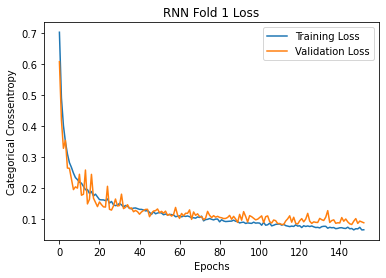

In [5]:
# plt.figure(figsize = [4,3])
plt.plot(history_fold_0.loc[:,['loss','val_loss']])
plt.legend(['Training Loss', 'Validation Loss'])
plt.title('RNN Fold 1 Loss')
plt.xlabel('Epochs')
plt.ylabel('Categorical Crossentropy')
plt.show()

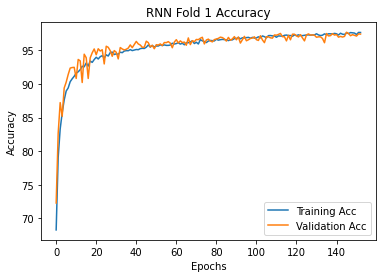

In [6]:
# plt.figure(figsize = [4,3])
plt.plot((history_fold_0.loc[:,['accuracy','val_accuracy']])*100)
plt.legend(['Training Acc', 'Validation Acc'])
plt.title('RNN Fold 1 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

### Fold 2

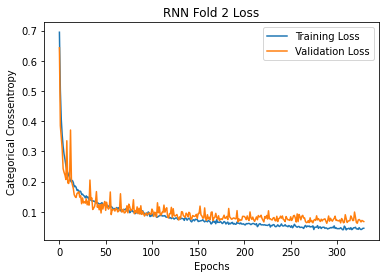

In [7]:
# plt.figure(figsize = [4,3])
plt.plot(history_fold_1.loc[:,['loss','val_loss']])
plt.legend(['Training Loss', 'Validation Loss'])
plt.title('RNN Fold 2 Loss')
plt.xlabel('Epochs')
plt.ylabel('Categorical Crossentropy')
plt.show()

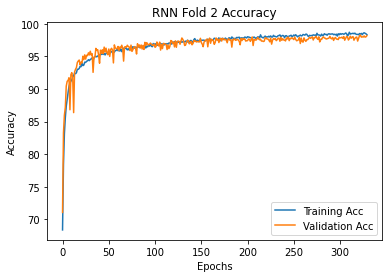

In [8]:
# plt.figure(figsize = [4,3])
plt.plot((history_fold_1.loc[:,['accuracy','val_accuracy']])*100)
plt.legend(['Training Acc', 'Validation Acc'])
plt.title('RNN Fold 2 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

### Fold 3

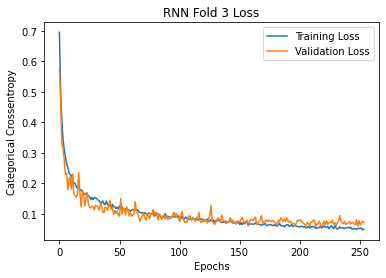

In [9]:
# plt.figure(figsize = [4,3])
plt.plot(history_fold_2.loc[:,['loss','val_loss']])
plt.legend(['Training Loss', 'Validation Loss'])
plt.title('RNN Fold 3 Loss')
plt.xlabel('Epochs')
plt.ylabel('Categorical Crossentropy')
plt.show()

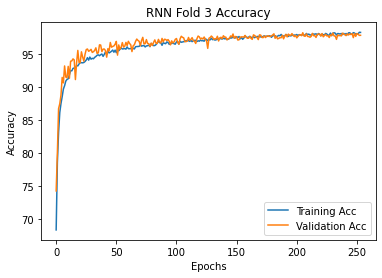

In [10]:
# plt.figure(figsize = [4,3])
plt.plot((history_fold_2.loc[:,['accuracy','val_accuracy']])*100)
plt.legend(['Training Acc', 'Validation Acc'])
plt.title('RNN Fold 3 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

### Fold 4

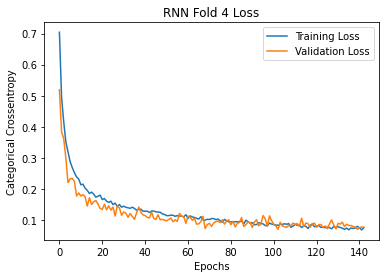

In [11]:
# plt.figure(figsize = [4,3])
plt.plot(history_fold_3.loc[:,['loss','val_loss']])
plt.legend(['Training Loss', 'Validation Loss'])
plt.title('RNN Fold 4 Loss')
plt.xlabel('Epochs')
plt.ylabel('Categorical Crossentropy')
plt.show()

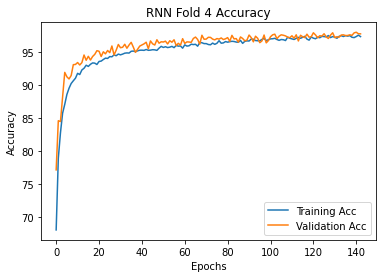

In [12]:
# plt.figure(figsize = [4,3])
plt.plot((history_fold_3.loc[:,['accuracy','val_accuracy']])*100)
plt.legend(['Training Acc', 'Validation Acc'])
plt.title('RNN Fold 4 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

### Fold 5

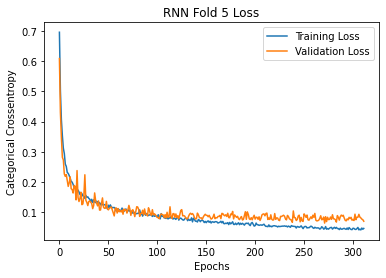

In [13]:
# plt.figure(figsize = [4,3])
plt.plot(history_fold_4.loc[:,['loss','val_loss']])
plt.legend(['Training Loss', 'Validation Loss'])
plt.title('RNN Fold 5 Loss')
plt.xlabel('Epochs')
plt.ylabel('Categorical Crossentropy')
plt.show()

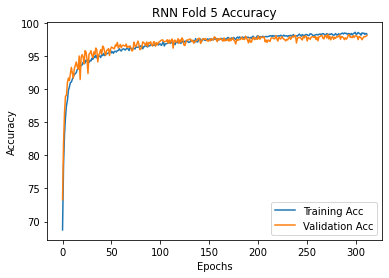

In [14]:
# plt.figure(figsize = [4,3])
plt.plot((history_fold_4.loc[:,['accuracy','val_accuracy']])*100)
plt.legend(['Training Acc', 'Validation Acc'])
plt.title('RNN Fold 5 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

### Final Accuracy and Loss

In [15]:
final_result = pd.concat([history_fold_0[-1:],
                          history_fold_1[-1:],
                          history_fold_2[-1:],
                          history_fold_3[-1:],
                          history_fold_4[-1:],
                         ])
final_result.columns = ['Last Training Loss (Crossentropy)', 'Last Training Accuracy', 'Last Validation Loss (Crossentropy)', 'Last Validation Accuracy']
final_result = final_result.reset_index(drop = True)
final_result.index += 1 
final_result.index.name = 'Fold'
final_result['Last Training Accuracy'] *= 100
final_result['Last Validation Accuracy'] *= 100
final_result['Last Training Loss (Crossentropy)'] = final_result['Last Training Loss (Crossentropy)'].round(5)
final_result['Last Validation Loss (Crossentropy)'] = final_result['Last Validation Loss (Crossentropy)'].round(5)
final_result['Last Training Accuracy'] = final_result['Last Training Accuracy'].round(2)
final_result['Last Validation Accuracy'] = final_result['Last Validation Accuracy'].round(2)

final_result

,Last Training Loss (Crossentropy),Last Training Accuracy,Last Validation Loss (Crossentropy),Last Validation Accuracy
Fold,,,,
1,0.06537,97.67,0.08796,97.43
2,0.04531,98.32,0.06747,98.18
3,0.04941,98.34,0.07074,97.90
4,0.07535,97.32,0.07775,97.74
5,0.04608,98.38,0.06981,98.16


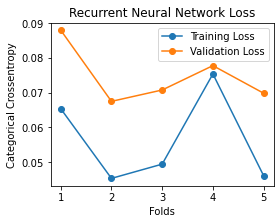

In [16]:
plt.figure(figsize = [4,3])
plt.plot(final_result.loc[:, ['Last Training Loss (Crossentropy)', 'Last Validation Loss (Crossentropy)']],'o-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.title('Recurrent Neural Network Loss')
plt.xticks(np.arange(1,6,1))
plt.xlabel('Folds')
plt.ylabel('Categorical Crossentropy')
plt.show()

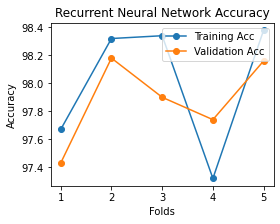

In [17]:
plt.figure(figsize = [4,3])
plt.plot(final_result.loc[:, ['Last Training Accuracy', 'Last Validation Accuracy']],'o-')
plt.legend(['Training Acc', 'Validation Acc'])
plt.title('Recurrent Neural Network Accuracy')
plt.xticks(np.arange(1, 6, 1))
plt.xlabel('Folds')
plt.ylabel('Accuracy')
plt.show()